# Simple topology optimization for a bookshelf
Let us consider a bookshelf, that needs a support structure. The picture below shows the available two-dimensional design domain for such a support. We could design a structure based on engineering intuition and may even simulate its performance. However, this approach does not necessarily result in the best possible design. Instead, we want to apply topology optimization to find the optimal distribution of material in the design space. This approach is not based on engineering intuition, but a formal data driven way to find a design suggestion for the bookshelf.

![domain](img/domain.png)

### Formalizing the problem statement

First, the problem is described as a boundary value problem with the design domain $\Omega$, the wall mount boundary $\partial \Omega_D$ and the load boundary $\partial \Omega_N$. Without considering the optimization yet, we can formulate the elastic problem as 

$$ \textrm{div}(\sigma) = 0 \quad \textrm{on} \quad \Omega $$

with the boundary conditions 

$$u = 0 \quad \textrm{on} \quad \partial\Omega_D $$

$$\sigma n = f \quad \textrm{on} \quad \partial\Omega_N. $$

We need to close this problem with a model that relates the stress $\sigma$ to $u$, such that the only remaining variables to solve are $u_1$ and $u_2$.



### Material model 

A material model is required to compute the stress $\sigma$ for a given strain field $\nabla^s u$. Here, $\nabla^s u$ denotes the symmetric strain gradient $\nabla^s u = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i} \right )$. An isotropic material model is used, which is defined by two parameters, e.g. Youngs modulus $E$ and poisson ratio $\nu$. The tensor notation of the isotropic material is 

$$\sigma = 2 \mu \nabla^s u + \lambda \textrm{tr}(\nabla^s u) I,$$ 

with the Lame constants 

$$ \mu = \frac{E}{2(1+\nu)} = E \mu' \quad \textrm{and} \quad \lambda = \frac{E\nu}{(1+\nu)(1-2\nu)} = E \lambda' .$$

The SIMP (Solid Isotropic Material with Penalization) approach is applied to compute 

$$ E = E_0 \hat{\rho}^p $$

with the normalized density $\hat{\rho} = \frac{\rho}{\rho_0}$.

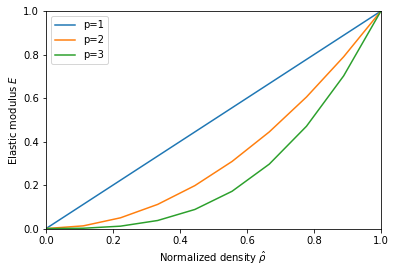

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Material parameters
p = 3
nu = 0.3
E0 = 1.0
mu_prime =  1.0 / (2.0 * (1.0 + nu))
lbd_prime = nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

# Plot the SIMP relation
rho_hat_plot = np.linspace(0,1,10)
plt.plot(rho_hat_plot, E0 * rho_hat_plot**1.0, label="p=1")
plt.plot(rho_hat_plot, E0 * rho_hat_plot**2.0, label="p=2")
plt.plot(rho_hat_plot, E0 * rho_hat_plot**3.0, label="p=3")
plt.xlabel(r"Normalized density $\hat{\rho}$")
plt.ylabel(r"Elastic modulus $E$")
plt.xlim([0, 1])
plt.ylim([0, E0])
plt.legend()
plt.show()


### Weak form of the momentum equation



The weak form of the momentum balance is 

$$\underbrace{\int_\Omega \left(2 \mu \nabla^s u + \lambda \textrm{tr}(\nabla^s u) I \right)  : \nabla^s v dV}_{a(u,v)} = \underbrace{\int_{\partial \Omega_N} f v \cdot n dA}_{b(v)}$$

In [156]:
%pip install scikit-fem
import skfem as fem
from skfem.helpers import dot, ddot, sym_grad, trace, eye

# Load at top.
f = 1.0

@fem.BilinearForm
def a(u, v, w):
    strain = sym_grad(u)
    stress = w.E * (2.0 * mu_prime * strain + lbd_prime * eye(trace(strain), 2))
    return ddot(stress, sym_grad(v))

@fem.LinearForm
def b(v, w):
    return f * dot(w.n, v)

Note: you may need to restart the kernel to use updated packages.


### Finite element mesh 
Create a finite element mesh with quadratic isoparametric elements. The parameter 'ref' defines, how often the square domain should be subdivided into smaller elements. A value of 0 results in a single element and a value of 1 results in four elements, because the square is subdivided in two parts in each direction x and y. A value of 2 results in 16 elements, 3 in 81 and so on...

The subdomain for the design space is defined such there is always one layer of elements at the load application region - there should be something to apply a load to. 

In [157]:
# Mesh and element
ref = 4
mesh = fem.mesh.MeshQuad1().refined(ref)
element = fem.ElementVector(fem.ElementQuad1())

# Tag top boundary and design subdomain
mesh = mesh.with_boundaries({"top": lambda x : x[1] == 1})
mesh = mesh.with_subdomains({"design": lambda x : x[1] <= 1.0-1.0/(2.0**ref)})

# Basis
basis = fem.Basis(mesh, element)
basis0 = basis.with_element(fem.ElementQuad0())
design_dofs = basis0.get_dofs(elements="design")

### Boundary conditions

In [158]:
load_basis = fem.FacetBasis(mesh, element, facets=mesh.boundaries["top"])

dofs = {'left' : basis.get_dofs(lambda x: x[0] == 0.0)}
u0 = basis.zeros()
I = basis.complement_dofs(dofs)

### Target function for topology optimization
The FEM discretization leads to a linear system of equations 

$$ Ku = B, $$

where $K$ is an $M \times M$  matrix and $B$ an $M \times 1$ vector with the degrees of freedom $M$. The system is solved, whenever this target function is called and the scalar strain energy 

$$ W = \frac{1}{2} u K u $$

is returned. 

In [159]:
def target_function(design):
    # Apply densities
    rho_hat = basis0.zeros() + 1.0
    rho_hat[design_dofs] = design

    # Penalized material property field
    E = E0 * rho_hat**p

    # Assembly
    K = fem.asm(a, basis, E=basis0.interpolate(E))
    B = fem.asm(b, load_basis)

    # Solution
    u = fem.solve(*fem.condense(K, B, x=u0, I=I))
    
    # Evaluation of strain energy
    return 0.5 * (u @ K @ u)

### Optimization
The optimization task is the minimization of the strain energy $W$ for a given maximum volume fraction $v$: 

$$ \textrm{mininimize} \quad W(\hat{\rho}) $$
subject to
$$ \sum_{i=0}^N \hat{\rho}_i < v N $$
$$ 0.01 < \hat{\rho}_i < 1.0 $$

/Users/nilsmeyer/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Success state:True
Iterations: 45
Solver message: Optimization terminated successfully
Final strain energy: 1.9805491228763867


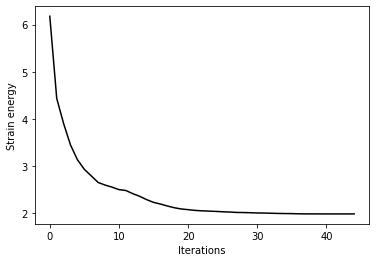

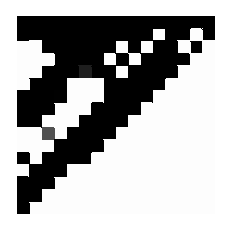

In [160]:
from skfem.visuals.matplotlib import plot
from scipy.optimize import minimize

# Volume constraint parameter
vol_constraint = 0.4

# Number of elements
N = len(basis0.get_dofs(elements="design").flatten())
# Initial guess is a homogeneous distribution 
rho0 = vol_constraint * np.ones(N)
# The design variables are limited to the range 0.01 to 1
bounds = N*[(0.01, 1.0)]
# The inequality constraint limits the maximum volume occupied by filled material
constraints = {'type':'ineq', 'fun': lambda x : vol_constraint*N-np.sum(x)}
# Save intermediate designs during optimization for plotting
designs = []
def callback(x, *args):
    designs.append(x)

# Run the actual optimization
res = minimize(
    target_function,
    rho0,
    constraints=constraints,
    bounds=bounds,
    callback=callback)
energies = [target_function(d) for d in designs]
print(f"Success state:{res.success}")
print(f"Iterations: {res.nit}")
print(f"Solver message: {res.message}")
print(f"Final strain energy: {energies[-1]}")

# Plot the optimization convergence
plt.plot(energies, "-k")
plt.xlabel("Iterations")
plt.ylabel("Strain energy")
plt.show()

# plot the resulting material distribution
rho = basis0.zeros() + 1.0
rho[design_dofs] = res.x
plot(mesh, rho, cmap=plt.cm.binary, vmin=0, vmax=1.0)
plt.show()